In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image

2024-04-01 21:42:13.326716: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 21:42:13.326807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 21:42:13.459752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
breast_img = glob.glob('/kaggle/input/ns-idc-data/NS_IDC_Data/I/*/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/kaggle/input/ns-idc-data/NS_IDC_Data/I/0/13591_idx5_x2951_y651_class0.png
/kaggle/input/ns-idc-data/NS_IDC_Data/I/0/13666_idx5_x1151_y251_class0.png
/kaggle/input/ns-idc-data/NS_IDC_Data/I/0/13024_idx5_x551_y601_class0.png


In [3]:
len(breast_img)

20000

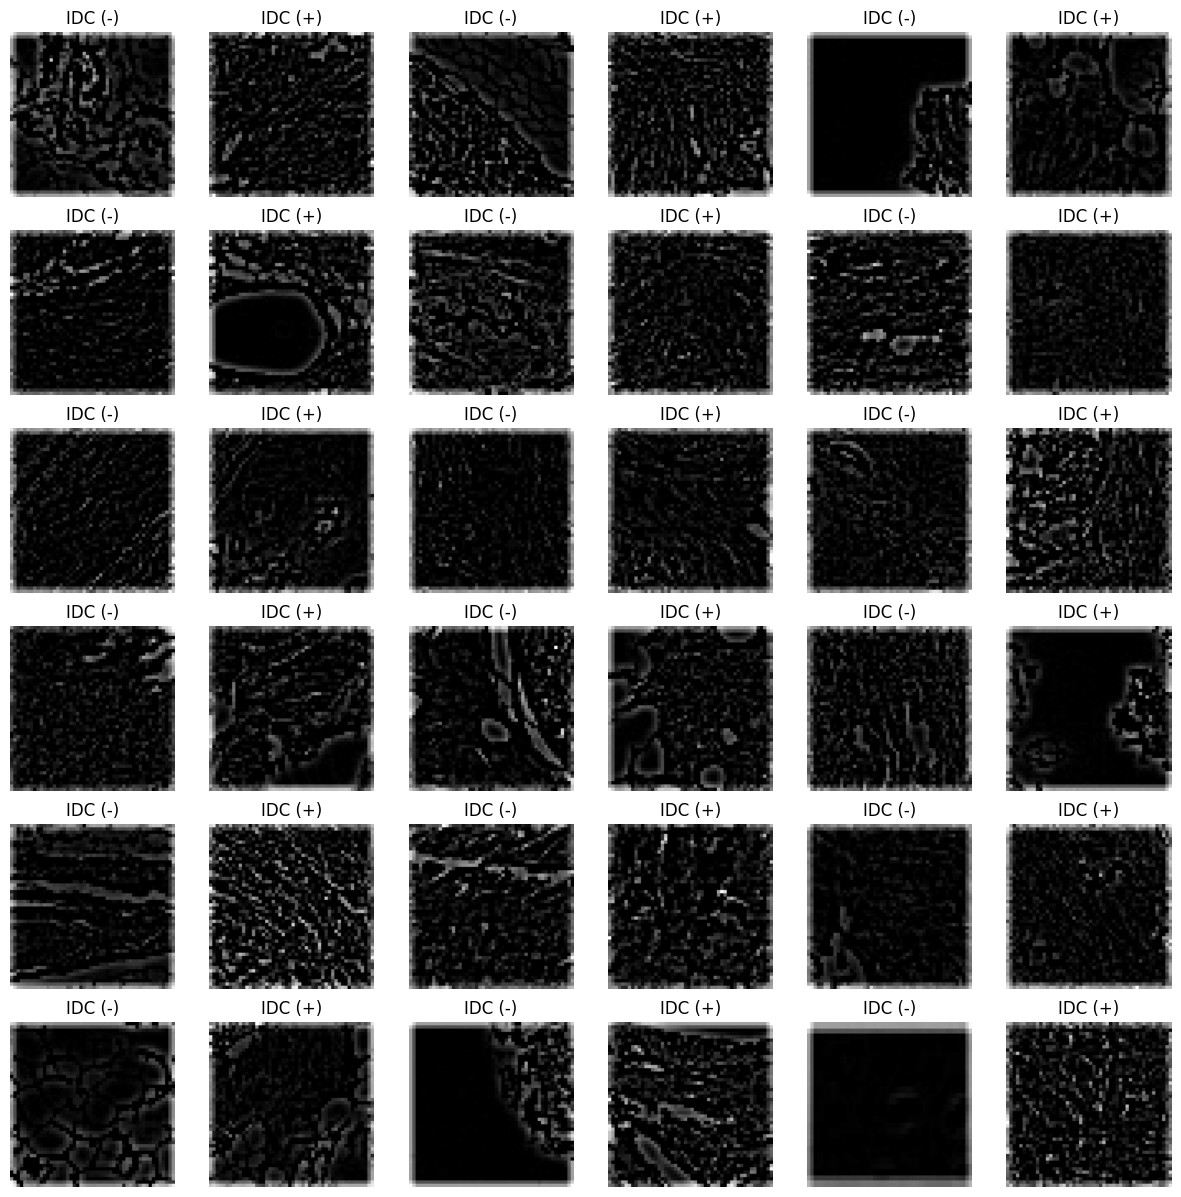

In [4]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)
        
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('IDC (-)')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

In [5]:
y = []
for img in breast_img:
    if img.endswith('class0.png'):
        y.append(0)
    elif img.endswith('class1.png'):
        y.append(1)

print(len(y))

images_df = pd.DataFrame()
images_df["images"] = breast_img
images_df["labels"] = y
print(images_df.head())
print()

def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a.shape))
describeData(cv2.imread(breast_img[0]),images_df["labels"])

20000
                                              images  labels
0  /kaggle/input/ns-idc-data/NS_IDC_Data/I/0/1359...       0
1  /kaggle/input/ns-idc-data/NS_IDC_Data/I/0/1366...       0
2  /kaggle/input/ns-idc-data/NS_IDC_Data/I/0/1302...       0
3  /kaggle/input/ns-idc-data/NS_IDC_Data/I/0/1026...       0
4  /kaggle/input/ns-idc-data/NS_IDC_Data/I/0/1025...       0

Total number of images: 50
Number of IDC(-) Images: 10000
Number of IDC(+) Images: 10000
Image shape (Width, Height, Channels): (50, 50, 3)


In [6]:
from sklearn.model_selection import train_test_split


# Step 1: Read the image paths and labels from the DataFrame
X_paths = images_df['images'].tolist()
y = images_df['labels'].tolist()

# Define a function to load and preprocess images
def load_images(image_paths):
    images = []
    for path in image_paths:
        image = cv2.imread(path) 
        #image = cv2.resize(image,(50, 50), interpolation = cv2.INTER_LINEAR)
        image = cv2.resize(image, (50, 50), interpolation = cv2.INTER_AREA)
        image = image / 255.0
        # Optionally, preprocess the images here (resize, normalize, etc.)
        images.append(image)
    return images

# Load images for train and test sets
X = load_images(X_paths)

In [7]:
# Step 2: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [8]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Training Data Shape:", y_train.shape)
print("Testing Data Shape:", y_test.shape)

Training Data Shape: (16000, 50, 50, 3)
Testing Data Shape: (4000, 50, 50, 3)
Training Data Shape: (16000,)
Testing Data Shape: (4000,)


# MODLING

In [9]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.models import Model

# VGG16 MODEL

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16


vgg_model=VGG16(input_shape=(50,50,3),include_top=False)
x=Flatten()(vgg_model.output)
prediction=Dense(2,activation='softmax')(x)
model=Model(inputs=vgg_model.input,outputs=prediction)
#model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
  5/250 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.4954 - loss: 0.9871 

I0000 00:00:1712007833.416956      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.6846 - loss: 0.6031 - val_accuracy: 0.6970 - val_loss: 0.6766
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.7425 - loss: 0.5311 - val_accuracy: 0.7600 - val_loss: 0.5001
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.7553 - loss: 0.5017 - val_accuracy: 0.7688 - val_loss: 0.4932
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.7721 - loss: 0.4789 - val_accuracy: 0.7685 - val_loss: 0.4946
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.7822 - loss: 0.4649 - val_accuracy: 0.7595 - val_loss: 0.5056
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8050 - loss: 0.4253 - val_accuracy: 0.7640 - val_loss: 0.5238
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8327 - loss: 0.3766 - val_accuracy: 0.7635 - val_loss: 0.5492
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8758 - loss: 0.2972 - val_accuracy: 0.76

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


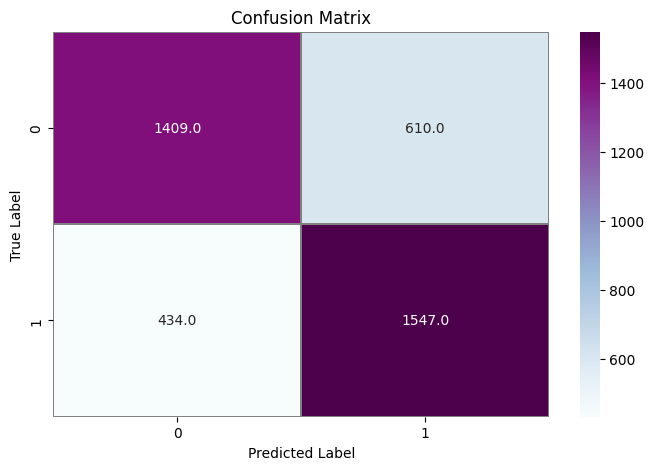

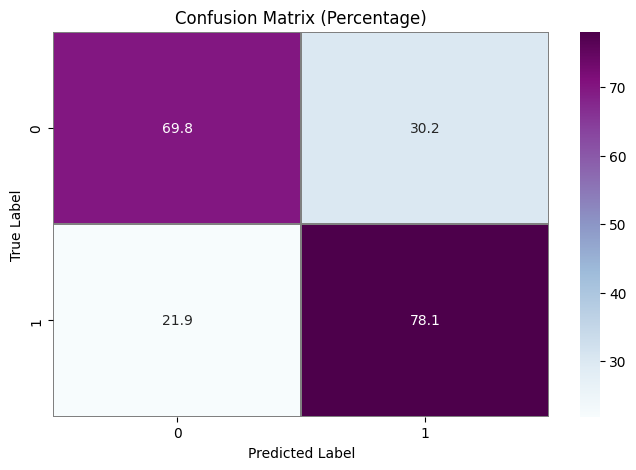

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7415 - loss: 1.7198
Test Loss: 1.7502803802490234
Test Accuracy: 0.7390000224113464


              precision    recall  f1-score   support

           0       0.76      0.70      0.73      2019
           1       0.72      0.78      0.75      1981

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



In [12]:
from sklearn.metrics import accuracy_score , confusion_matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

#  VGG19 MODEL

In [13]:
from tensorflow.keras.applications import VGG19

# Load the pre-trained VGG19 model (without the top classification layer)
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the VGG19 base model
x = Flatten()(vgg_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=vgg_model.input, outputs=prediction)
#model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.6402 - loss: 0.6554 - val_accuracy: 0.7558 - val_loss: 0.5187
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7353 - loss: 0.5363 - val_accuracy: 0.7638 - val_loss: 0.5145
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7549 - loss: 0.5127 - val_accuracy: 0.7165 - val_loss: 0.5525
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7547 - loss: 0.5104 - val_accuracy: 0.7605 - val_loss: 0.5015
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7621 - loss: 0.4994 - val_accuracy: 0.7628 - val_loss: 0.5096
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7736 - loss: 0.4774 - val_accuracy: 0.7673 - val_loss: 0.5121
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7894 - loss: 0.4601 - val_accuracy: 0.7670 - val_loss: 0.4908
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7942 - loss: 0.4517 - 

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


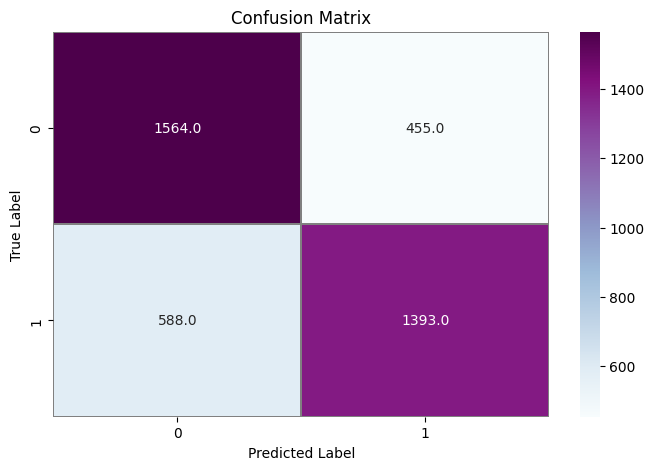

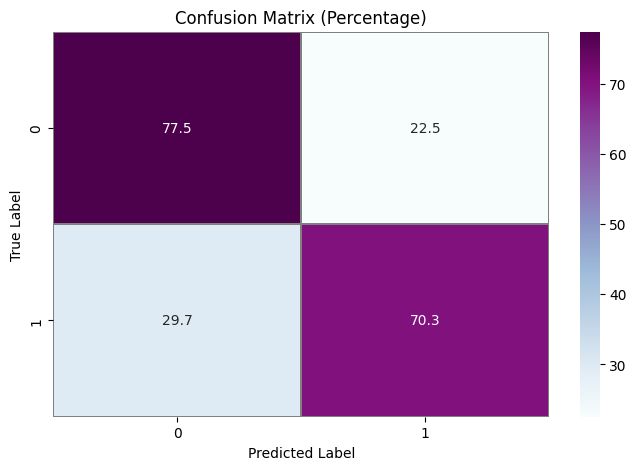

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7356 - loss: 1.3736
Test Loss: 1.3814293146133423
Test Accuracy: 0.7392500042915344


              precision    recall  f1-score   support

           0       0.73      0.77      0.75      2019
           1       0.75      0.70      0.73      1981

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



In [15]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

# ResNet50

In [16]:
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model (without the top classification layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the ResNet50 base model
x = Flatten()(resnet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=resnet_model.input, outputs=prediction)
#model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 77ms/step - accuracy: 0.6923 - loss: 0.8149 - val_accuracy: 0.5048 - val_loss: 25.0436
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.8185 - loss: 0.4527 - val_accuracy: 0.5048 - val_loss: 7.5791
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.8858 - loss: 0.2947 - val_accuracy: 0.4947 - val_loss: 2.6775
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9453 - loss: 0.1616 - val_accuracy: 0.5070 - val_loss: 1.9698
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9634 - loss: 0.1077 - val_accuracy: 0.5870 - val_loss: 1.1163
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9775 - loss: 0.0691 - val_accuracy: 0.7130 - val_loss: 0.7835
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9806 - loss: 0.0613 - val_accuracy: 0.7375 - val_loss: 0.9062
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9795 - loss: 0.0601 -

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


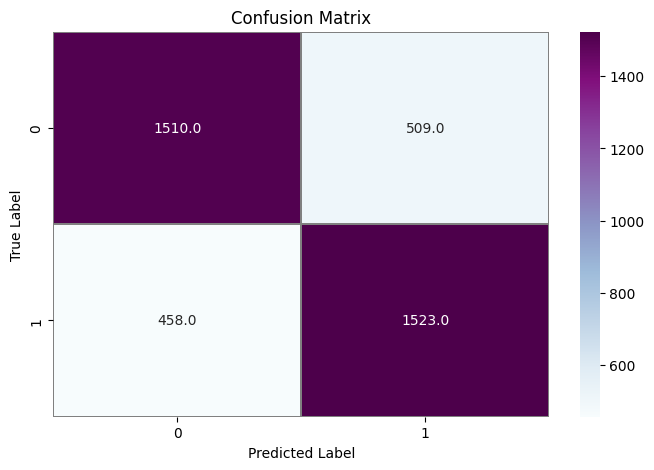

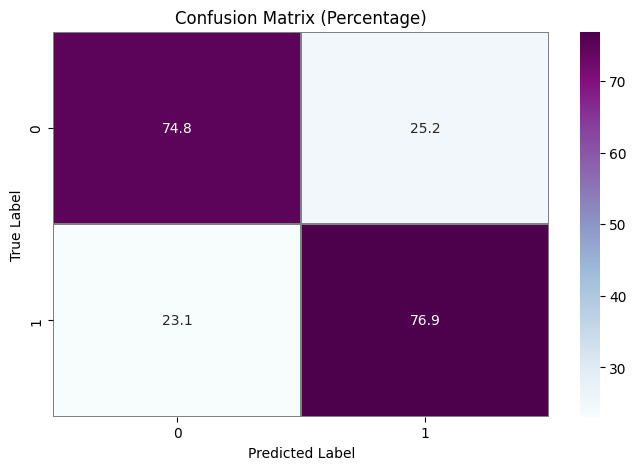

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7652 - loss: 1.5527
Test Loss: 1.7144123315811157
Test Accuracy: 0.7582499980926514


              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2019
           1       0.75      0.77      0.76      1981

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



In [18]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

# ResNet152

In [19]:
from tensorflow.keras.applications import ResNet152


# Load the pre-trained ResNet152 model (without the top classification layer)
resnet_model = ResNet152(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the ResNet152 base model
x = Flatten()(resnet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=resnet_model.input, outputs=prediction)

#model.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 196s 190ms/step - accuracy: 0.6947 - loss: 0.8052 - val_accuracy: 0.4975 - val_loss: 0.6848
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - accuracy: 0.7898 - loss: 0.5127 - val_accuracy: 0.4950 - val_loss: 0.7556
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - accuracy: 0.8308 - loss: 0.4236 - val_accuracy: 0.6090 - val_loss: 0.6661
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - accuracy: 0.9216 - loss: 0.2150 - val_accuracy: 0.4995 - val_loss: 1.3060
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 132ms/step - accuracy: 0.9679 - loss: 0.1079 - val_accuracy: 0.5270 - val_loss: 1.3748
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - accuracy: 0.9743 - loss: 0.0839 - val_accuracy: 0.6202 - val_loss: 1.4834
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 132ms/step - accuracy: 0.8946 - loss: 0.3357 - val_accuracy: 0.7343 - val_loss: 0.9520
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - accuracy: 0.9672 - loss: 

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step


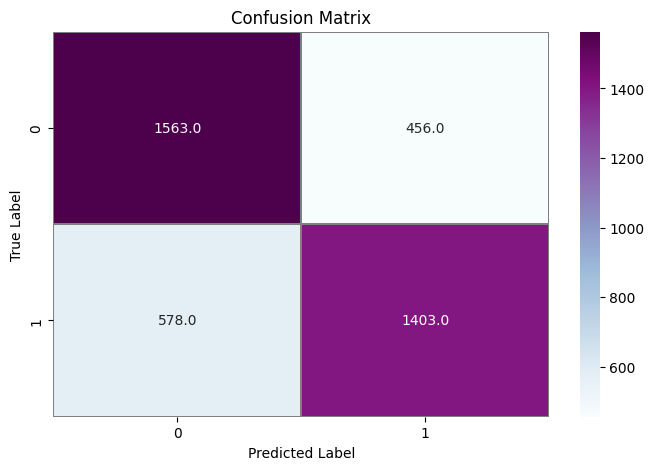

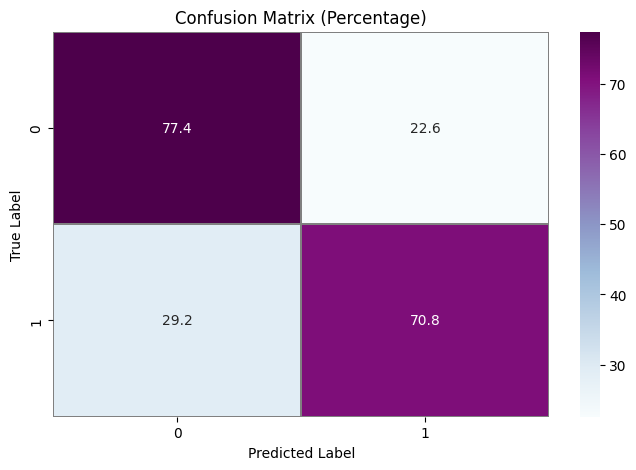

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7463 - loss: 1.0697
Test Loss: 1.123642086982727
Test Accuracy: 0.7415000200271606


              precision    recall  f1-score   support

           0       0.73      0.77      0.75      2019
           1       0.75      0.71      0.73      1981

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



In [21]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

# DenseNet121 Model

In [22]:
from tensorflow.keras.applications import DenseNet121

# Load the pre-trained DenseNet121 model (without the top classification layer)
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the DenseNet121 base model
x = Flatten()(densenet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=densenet_model.input, outputs=prediction)
#model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 157s 143ms/step - accuracy: 0.6720 - loss: 0.7279 - val_accuracy: 0.6965 - val_loss: 0.6511
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.7757 - loss: 0.4922 - val_accuracy: 0.7042 - val_loss: 0.6221
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.8212 - loss: 0.4143 - val_accuracy: 0.7235 - val_loss: 0.6070
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.8641 - loss: 0.3269 - val_accuracy: 0.7452 - val_loss: 0.6114
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9074 - loss: 0.2396 - val_accuracy: 0.7335 - val_loss: 0.7051
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9359 - loss: 0.1718 - val_accuracy: 0.6920 - val_loss: 0.8003
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9501 - loss: 0.1350 - val_accuracy: 0.7340 - val_loss: 0.9070
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9623 - loss: 0.1040 

125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step


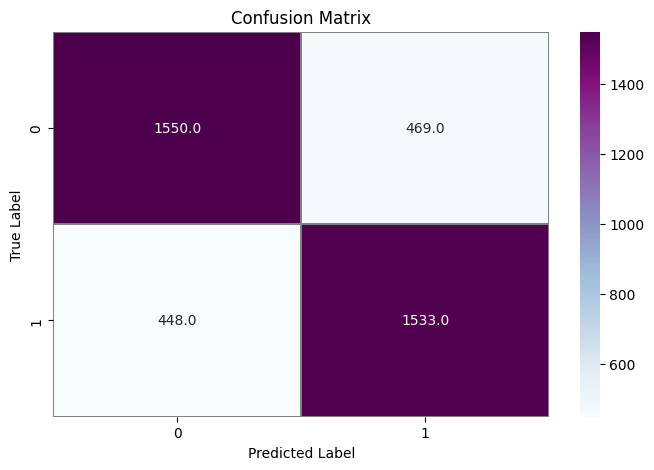

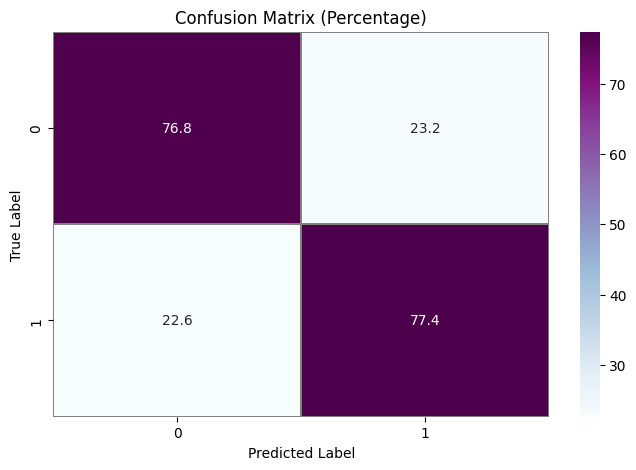

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7799 - loss: 1.7322
Test Loss: 1.8277496099472046
Test Accuracy: 0.7707499861717224


              precision    recall  f1-score   support

           0       0.78      0.77      0.77      2019
           1       0.77      0.77      0.77      1981

    accuracy                           0.77      4000
   macro avg       0.77      0.77      0.77      4000
weighted avg       0.77      0.77      0.77      4000



In [24]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

# EfficientNetB0

In [25]:
from tensorflow.keras.applications import EfficientNetB0

# Load the pre-trained EfficientNetB0 model (without the top classification layer)
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the EfficientNetB0 base model
x = Flatten()(efficientnet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=efficientnet_model.input, outputs=prediction)
#model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 97s 77ms/step - accuracy: 0.6565 - loss: 0.6988 - val_accuracy: 0.5048 - val_loss: 0.7719
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.7695 - loss: 0.4985 - val_accuracy: 0.5038 - val_loss: 1.0383
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8178 - loss: 0.4074 - val_accuracy: 0.6298 - val_loss: 0.7095
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8388 - loss: 0.3607 - val_accuracy: 0.7088 - val_loss: 0.6376
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8781 - loss: 0.2991 - val_accuracy: 0.7295 - val_loss: 0.6202
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9048 - loss: 0.2510 - val_accuracy: 0.7280 - val_loss: 0.6487
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9182 - loss: 0.2180 - val_accuracy: 0.7260 - val_loss: 0.6669
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9379 - loss: 0.1719 - val_acc

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


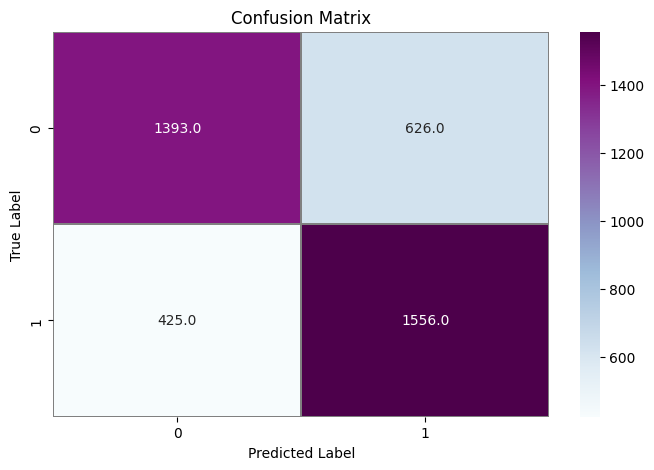

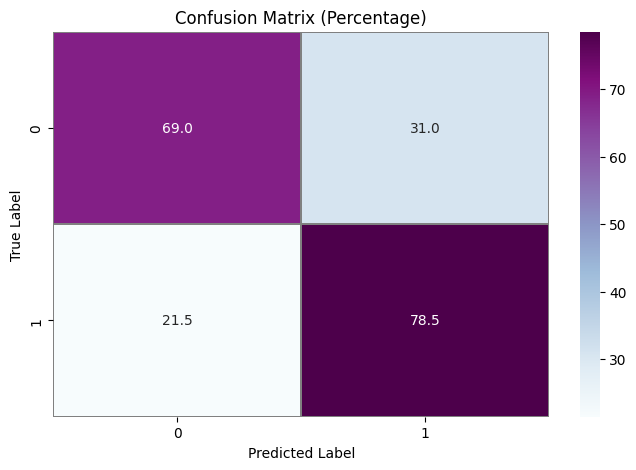

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7395 - loss: 1.3389
Test Loss: 1.3759634494781494
Test Accuracy: 0.7372499704360962


              precision    recall  f1-score   support

           0       0.77      0.69      0.73      2019
           1       0.71      0.79      0.75      1981

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



In [27]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

# MobileNetV2 Model

In [28]:
from tensorflow.keras.applications import MobileNetV2

# Load the pre-trained MobileNetV2 model (without the top classification layer)
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the MobileNetV2 base model
x = Flatten()(mobilenet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=mobilenet_model.input, outputs=prediction)
#model.summary()

/tmp/ipykernel_34/1739306031.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(50, 50, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - accuracy: 0.6589 - loss: 0.7528 - val_accuracy: 0.5480 - val_loss: 1.3470
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7657 - loss: 0.4994 - val_accuracy: 0.5222 - val_loss: 1.6606
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7927 - loss: 0.4557 - val_accuracy: 0.5480 - val_loss: 1.3248
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8010 - loss: 0.4298 - val_accuracy: 0.5412 - val_loss: 1.1571
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8453 - loss: 0.3606 - val_accuracy: 0.6068 - val_loss: 0.9951
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8665 - loss: 0.3192 - val_accuracy: 0.6392 - val_loss: 0.7804
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8831 - loss: 0.2774 - val_accuracy: 0.6790 - val_loss: 0.6880
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9098 - loss: 0.2276 - val_acc

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


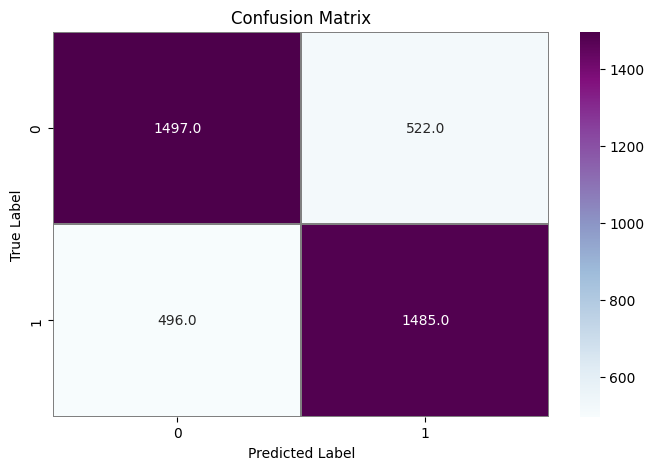

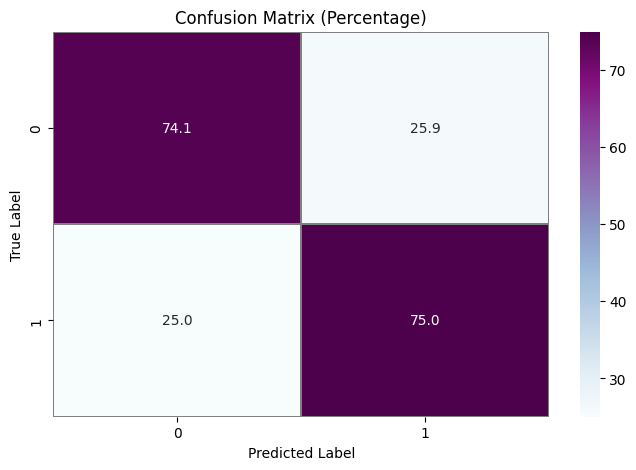

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7568 - loss: 1.6084
Test Loss: 1.71261465549469
Test Accuracy: 0.7455000281333923


              precision    recall  f1-score   support

           0       0.75      0.74      0.75      2019
           1       0.74      0.75      0.74      1981

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



In [30]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))